<a href="https://colab.research.google.com/github/aayushmanda/da6401_assignment3/blob/main/asg3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import random
import re
from prettytable import PrettyTable
import matplotlib.pyplot as plt

In [ ]:
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
!tar -xvf dakshina_dataset_v1.0.tar


--2025-05-19 13:55:03--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.207, 74.125.139.207, 173.194.210.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.134.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G  99.7MB/s    in 11s     

2025-05-19 13:55:14 (173 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]

dakshina_dataset_v1.0/bn/
dakshina_dataset_v1.0/bn/lexicons/
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv
dakshina_dataset_v1.0/bn/native_script_wikipedia/
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.valid.text.shuf.txt.g

In [ ]:
# Define a dataset class for transliteration data
class TransliterationDataset(Dataset):
    def __init__(self, data_path, input_lang, target_lang, max_len=50):
        """
        Args:
            data_path: Path to the data file with pairs of words
            input_lang: The input language/script processor object
            target_lang: The target language/script processor object
            max_len: Maximum sequence length
        """
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.max_len = max_len
        self.pairs = []

        # Load data
        with open(data_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    # Format may vary depending on dataset
                    latin, native = parts[0], parts[1]
                    if latin and native and len(latin) <= max_len and len(native) <= max_len:
                        self.pairs.append((latin, native))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        latin_word, native_word = self.pairs[idx]

        # Convert characters to indices
        input_tensor = self.input_lang.word_to_tensor(latin_word, self.max_len)
        target_tensor = self.target_lang.word_to_tensor(native_word, self.max_len)

        return input_tensor, target_tensor




In [ ]:

# Language class to handle character-level processing
class Lang:
    def __init__(self, name):
        self.name = name
        self.char2index = {"PAD": 0, "SOS": 1, "EOS": 2}
        self.char2count = {}
        self.index2char = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_chars = 3  # Count PAD, SOS and EOS

    def add_word(self, word):
        for char in word:
            self.add_char(char)

    def add_char(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

    def word_to_tensor(self, word, max_len):
        """Convert a word to tensor of character indices with padding"""
        indices = [self.char2index.get(char, 0) for char in word]
        indices = [self.char2index["SOS"]] + indices + [self.char2index["EOS"]]

        # Pad sequence to max_len
        if len(indices) < max_len + 2:  # +2 for SOS and EOS
            indices += [self.char2index["PAD"]] * (max_len + 2 - len(indices))
        else:
            indices = indices[:max_len + 2]

        return torch.tensor(indices, dtype=torch.long)


In [ ]:

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
# Function to prepare data for a language pair
def prepare_data(data_path, max_len=50, input_lang=None, output_lang=None): # Add input_lang and output_lang arguments with default None
    if input_lang is None:  # If not provided, create new Lang objects
        input_lang = Lang("latin")
    if output_lang is None:
        output_lang = Lang("native")

    # Read data and build vocabulary
    pairs = []
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                latin, native = parts[0], parts[1]
                if latin and native and len(latin) <= max_len and len(native) <= max_len:
                    input_lang.add_word(latin)
                    output_lang.add_word(native)
                    pairs.append((latin, native))

    print(f"Prepared {len(pairs)} pairs")
    print(f"Input vocabulary size: {input_lang.n_chars}")
    print(f"Output vocabulary size: {output_lang.n_chars}")

    return input_lang, output_lang, pairs

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, cell_type="LSTM"):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type

        self.embedding = nn.Embedding(input_size, hidden_size)

        if cell_type == "LSTM":
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        elif cell_type == "GRU":
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        else:  # Default to vanilla RNN
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)

    def forward(self, input_seq, hidden):
        # input_seq shape: [batch_size, seq_len]
        batch_size = input_seq.size(0)

        embedded = self.embedding(input_seq)  # [batch_size, seq_len, hidden_size]
        output, hidden = self.rnn(embedded, hidden)

        return output, hidden

    def init_hidden(self, batch_size, device):
        if self.cell_type == "LSTM":
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
        else:
            return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, cell_type="LSTM"):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.cell_type = cell_type

        self.embedding = nn.Embedding(output_size, hidden_size)

        if cell_type == "LSTM":
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        elif cell_type == "GRU":
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        else:  # Default to vanilla RNN
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)

        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_seq, hidden):
        # input_seq shape: [batch_size, 1]
        batch_size = input_seq.size(0)

        embedded = self.embedding(input_seq)  # [batch_size, 1, hidden_size]
        output, hidden = self.rnn(embedded, hidden)

        output = self.softmax(self.out(output))
        return output, hidden

class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_size

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Initialize encoder hidden state
        encoder_hidden = self.encoder.init_hidden(batch_size, self.device)

        # Encode the source sequence
        encoder_outputs, encoder_hidden = self.encoder(src, encoder_hidden)

        # First decoder input is the SOS token
        decoder_input = src[:, 0:1]  # Use batch_size SOS tokens
        decoder_hidden = encoder_hidden

        for t in range(1, trg_len):
            # Pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)

            # Store prediction
            outputs[:, t:t+1, :] = decoder_output

            # Decide whether to use teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = decoder_output.argmax(2)

            # Use teacher forcing or not
            decoder_input = trg[:, t:t+1] if teacher_force else top1

        return outputs


In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device, train_lossi):
    model.train()
    epoch_loss = 0

    for batch_idx, (src, trg) in enumerate(dataloader):
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = model(src, trg)

        # Reshape for loss calculation
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)  # Skip SOS token
        trg = trg[:, 1:].reshape(-1)  # Skip SOS token

        # Calculate loss
        loss = criterion(output, trg)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        epoch_loss += loss.item()
        train_lossi.append(loss.item())

    return epoch_loss / len(dataloader), train_lossi

# Updated evaluate
def evaluate(model, dataloader, criterion, device, val_lossi):
    model.eval()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, teacher_forcing_ratio=0)

            # Reshape for loss calculation
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)  # Skip SOS token
            trg = trg[:, 1:].reshape(-1)  # Skip SOS token

            # Calculate loss
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            val_lossi.append(loss.item())

            # Calculate accuracy
            predictions = output.argmax(1)
            correct_mask = (predictions == trg) & (trg != 0)  # Exclude padding
            correct_predictions += correct_mask.sum().item()
            total_mask = trg != 0  # Exclude padding
            total_predictions += total_mask.sum().item()

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return epoch_loss / len(dataloader), accuracy, val_lossi


In [ ]:
def transliterate(model, src, input_lang, output_lang, device, max_length=30):
    model.eval()
    with torch.no_grad():
        # Reshape input to have batch size of 1: (seq_len, batch_size=1)
        src = src.unsqueeze(0)  # Add a batch dimension

        # Move to device
        src = src.to(device)

        # Initialize hidden state with batch_size=1
        batch_size = 1  # Explicitly set batch size to 1
        encoder_hidden = model.encoder.init_hidden(batch_size, device)  # Shape: (num_layers, 1, hidden_size)

        # Encoder forward pass
        encoder_outputs, encoder_hidden = model.encoder(src, encoder_hidden)

        # Decoder
        decoder_input = torch.tensor([[1]], device=device)  # SOS token
        decoder_hidden = encoder_hidden  # Shape: (num_layers, 1, hidden_size)
        output_chars = []

        for _ in range(max_length):
            decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden)
            _, topi = decoder_output.topk(1)
            char_idx = topi.item()

            if char_idx == 2:  # EOS token
                break

            output_chars.append(output_lang.index2char[char_idx])
            decoder_input = torch.tensor([[char_idx]], device=device)

        return ''.join(output_chars)

In [ ]:

# Updated main function
def main():
    # Parameters
    batch_size = 64
    hidden_size = 256
    learning_rate = 0.001
    num_epochs = 5
    cell_type = "LSTM"
    num_layers = 2
    data_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
    val_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
    test_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Prepare data
    input_lang, output_lang, train_pairs = prepare_data(data_path)
    _, _, val_pairs = prepare_data(val_path, input_lang=input_lang, output_lang=output_lang)
    _, _, test_pairs = prepare_data(test_path, input_lang=input_lang, output_lang=output_lang)

    # Create datasets and dataloaders
    train_dataset = TransliterationDataset(data_path, input_lang, output_lang)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TransliterationDataset(val_path, input_lang, output_lang)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    test_dataset = TransliterationDataset(test_path, input_lang, output_lang)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Create model
    encoder = EncoderRNN(input_lang.n_chars, hidden_size, num_layers, cell_type)
    decoder = DecoderRNN(hidden_size, output_lang.n_chars, num_layers, cell_type)
    model = Seq2SeqModel(encoder, decoder, device).to(device)
    count_parameters(model)

    # Define loss function and optimizer
    criterion = nn.NLLLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    best_val_loss = float('inf')
    train_lossi = []  # Per-batch training losses
    val_lossi = []    # Per-batch validation losses

    for epoch in range(num_epochs):
        # Train
        train_loss, train_lossi = train_epoch(model, train_loader, optimizer, criterion, device, train_lossi)
        # Validate
        val_loss, val_accuracy, val_lossi = evaluate(model, val_loader, criterion, device, val_lossi)

        print(f"Epoch: {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_transliteration_model.pt")
            print("Model saved!")

        print("-----")

    # Plot per-batch training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_lossi, label='Training Loss ')
    plt.plot(val_lossi, label='Validation Loss ')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Per-Batch Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on test set
    model.load_state_dict(torch.load("best_transliteration_model.pt"))
    test_loss, test_accuracy, _ = evaluate(model, test_loader, criterion, device, [])
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Example transliteration
    for i in range(min(10, len(test_dataset))):
        src, trg = test_dataset[i]
        src_text = ''.join([input_lang.index2char[idx.item()] for idx in src if idx.item() > 2])
        trg_text = ''.join([output_lang.index2char[idx.item()] for idx in trg if idx.item() > 2])

        pred_text = transliterate(model, src, input_lang, output_lang, device)

        print(f"Input: {src_text}")
        print(f"Target: {trg_text}")
        print(f"Prediction: {pred_text}")
        print("-----")




Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29
+--------------------------+------------+
|         Modules          | Parameters |
+--------------------------+------------+
| encoder.embedding.weight |   16896    |
| encoder.rnn.weight_ih_l0 |   262144   |
| encoder.rnn.weight_hh_l0 |   262144   |
|  encoder.rnn.bias_ih_l0  |    1024    |
|  encoder.rnn.bias_hh_l0  |    1024    |
| encoder.rnn.weight_ih_l1 |   262144   |
| encoder.rnn.weight_hh_l1 |   262144   |
|  encoder.rnn.bias_ih_l1  |    1024    |
|  encoder.rnn.bias_hh_l1  |    1024    |
| decoder.embedding.weight |    7424    |
| decoder.rnn.weight_ih_l0 |   262144   |
| decoder.rnn.weight_hh_l0 |   262144   |
|  decoder.rnn.bias_ih_l0  |    1024    |
|  decoder.rnn.bias_hh_l0  |    1024    |
| decoder.rnn.weight_ih_l1 |   262144   |
| dec

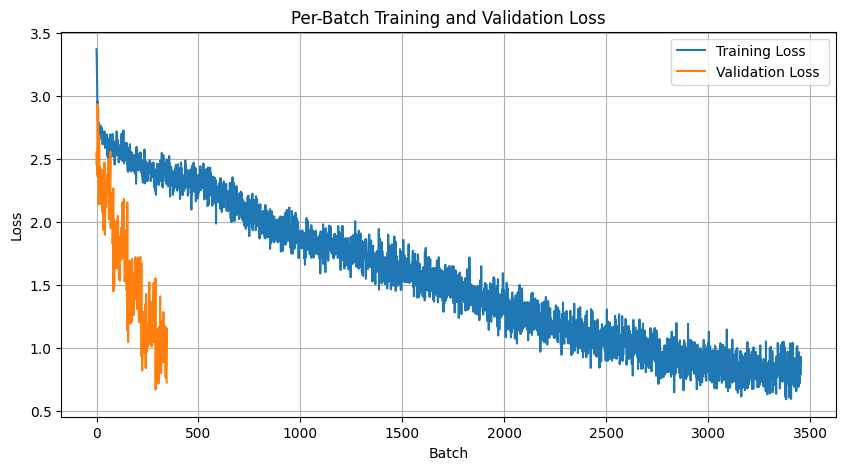

Test Loss: 1.0341
Test Accuracy: 0.6630
Input: अंक
Target: ank
Prediction: ank
-----
Input: अंक
Target: anka
Prediction: ank
-----
Input: अंकित
Target: ankit
Prediction: ankit
-----
Input: अंकों
Target: anakon
Prediction: ankon
-----
Input: अंकों
Target: ankhon
Prediction: ankon
-----
Input: अंकों
Target: ankon
Prediction: ankon
-----
Input: अंकोर
Target: angkor
Prediction: ankor
-----
Input: अंकोर
Target: ankor
Prediction: ankor
-----
Input: अंगारक
Target: angaarak
Prediction: angark
-----
Input: अंगारक
Target: angarak
Prediction: angark
-----


In [ ]:
main()

In [ ]:
for batch_idx, (src, trg) in enumerate(train_loader):
  src, trg = src.to(device), trg.to(device)



  print(src.shape)
  print(trg.shape)
  # Forward pass
  output = model(src, trg)

  # Reshape for loss calculation
  output_dim = output.shape[-1]
  output = output[:, 1:].reshape(-1, output_dim)  # Skip SOS token
  trg = trg[:, 1:].reshape(-1)  # Skip SOS token
  break

torch.Size([64, 52])
torch.Size([64, 52])


In [ ]:
src[1]

tensor([ 1, 31, 16,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       device='cuda:0')

In [ ]:

# Parameters
batch_size = 64
hidden_size = 256
learning_rate = 0.001
num_epochs = 5
cell_type = "LSTM"  # "RNN", "GRU", or "LSTM"
num_layers = 2
data_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
val_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
test_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare data
print("Train")
input_lang, output_lang, train_pairs = prepare_data(data_path)
print("Val")
_, _, val_pairs = prepare_data(val_path, input_lang=input_lang, output_lang=output_lang) # Pass existing Lang objects to prepare_data
print("Test")
_, _, test_pairs = prepare_data(test_path, input_lang=input_lang, output_lang=output_lang) # Pass existing Lang objects to prepare_data

# Create datasets and dataloaders
train_dataset = TransliterationDataset(data_path, input_lang, output_lang)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TransliterationDataset(val_path, input_lang, output_lang)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TransliterationDataset(test_path, input_lang, output_lang)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Create model
encoder = EncoderRNN(input_lang.n_chars, hidden_size, num_layers, cell_type)
decoder = DecoderRNN(hidden_size, output_lang.n_chars, num_layers, cell_type)
model = Seq2SeqModel(encoder, decoder, device).to(device)

# Define loss function and optimizer
criterion = nn.NLLLoss(ignore_index=0)  # Ignore padding index (0)




# Evaluate on test set
model.load_state_dict(torch.load("best_transliteration_model.pt"))
test_loss, test_accuracy, val_lossi = evaluate(model, test_loader, criterion, device, []) # Pass an empty list for val_lossi
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Example transliteration
# Example transliteration
for i in range(10):
    src, trg = test_dataset[i]
    src_text = ''.join([input_lang.index2char[idx.item()] for idx in src if idx.item() > 2])
    trg_text = ''.join([output_lang.index2char[idx.item()] for idx in trg if idx.item() > 2])

    pred_text = transliterate(model, src, input_lang, output_lang, device)

    print(f"Input: {src_text}")
    print(f"Target: {trg_text}")
    print(f"Prediction: {pred_text}")
    print("-----")




Using device: cuda
Train
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Val
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Test
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Test Loss: 1.2253
Test Accuracy: 0.6080
Input: अंक
Target: ank
Prediction: ank
-----
Input: अंक
Target: anka
Prediction: ank
-----
Input: अंकित
Target: ankit
Prediction: anutt
-----
Input: अंकों
Target: anakon
Prediction: ankon
-----
Input: अंकों
Target: ankhon
Prediction: ankon
-----
Input: अंकों
Target: ankon
Prediction: ankon
-----
Input: अंकोर
Target: angkor
Prediction: anuur
-----
Input: अंकोर
Target: ankor
Prediction: anuur
-----
Input: अंगारक
Target: angaarak
Prediction: anjaaka
-----
Input: अंगारक
Target: angarak
Prediction: anjaaka
-----


#Sweep

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
import wandb

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, cell_type="LSTM", dropout=0.0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type

        self.embedding = nn.Embedding(input_size, hidden_size)

        if cell_type == "LSTM":
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers,
                             batch_first=True, dropout=dropout if num_layers > 1 else 0)
        elif cell_type == "GRU":
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        else:
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, input_seq, hidden):
        embedded = self.embedding(input_seq)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self, batch_size, device):
        if self.cell_type == "LSTM":
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, cell_type="LSTM", dropout=0.0):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.cell_type = cell_type

        self.embedding = nn.Embedding(output_size, hidden_size)

        if cell_type == "LSTM":
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers,
                             batch_first=True, dropout=dropout if num_layers > 1 else 0)
        elif cell_type == "GRU":
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        else:
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)

        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_seq, hidden):
        embedded = self.embedding(input_seq)
        output, hidden = self.rnn(embedded, hidden)
        output = self.softmax(self.out(output))
        return output, hidden

class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_hidden = self.encoder.init_hidden(batch_size, self.device)
        _, encoder_hidden = self.encoder(src, encoder_hidden)

        decoder_input = src[:, 0:1]
        decoder_hidden = encoder_hidden

        for t in range(1, trg_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[:, t:t+1, :] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = decoder_output.argmax(2)
            decoder_input = trg[:, t:t+1] if teacher_force else top1

        return outputs




In [ ]:
def sweep():
    # Initialize W&B run (automatically handles sweep config)
    wandb.init(project="transliteration-sweep")
    config = wandb.config
    wandb.run.name = f"{config.cell_type}_hs{config.hidden_size}_nl{config.num_layers}_bs{config.batch_size}_lr{config.learning_rate}_do{config.dropout}"

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Data paths (consider moving to config if variable between environments)
    data_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
    val_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
    test_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"


    # Prepare data
    input_lang, output_lang, train_pairs = prepare_data(data_path)
    # Reuse input_lang and output_lang for validation and test sets
    _, _, val_pairs = prepare_data(val_path, input_lang=input_lang, output_lang=output_lang)
    _, _, test_pairs = prepare_data(test_path, input_lang=input_lang, output_lang=output_lang)


    # Create datasets and dataloaders
    train_dataset = TransliterationDataset(data_path, input_lang, output_lang)
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True) # Use config for batch size
    val_dataset = TransliterationDataset(val_path, input_lang, output_lang)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size) # Use config for batch size
    test_dataset = TransliterationDataset(test_path, input_lang, output_lang)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size) # Use config for batch size


    encoder = EncoderRNN(
        input_lang.n_chars,
        hidden_size=config.hidden_size,
        num_layers=config.num_layers,
        cell_type=config.cell_type,
        dropout=config.dropout # Pass dropout from config
    )

    decoder = DecoderRNN(
        hidden_size=config.hidden_size,
        output_size=output_lang.n_chars,
        num_layers=config.num_layers,
        cell_type=config.cell_type,
        dropout=config.dropout # Pass dropout from config
    )


    model = Seq2SeqModel(encoder, decoder, device).to(device)

    # Log model architecture
    wandb.watch(model, log="all", log_freq=100)

    # Optimization setup
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.NLLLoss(ignore_index=0)


    # Training lifecycle
    best_val_loss = float('inf')
    train_lossi = []
    val_lossi = []

    for epoch in range(config.num_epochs):
        # Train & validate
        train_loss, train_lossi = train_epoch(model, train_loader, optimizer, criterion, device, train_lossi)
        val_loss, val_accuracy, val_lossi = evaluate(model, val_loader, criterion, device, val_lossi)

        # Log metrics
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "learning_rate": config.learning_rate
        })



        # Console reporting
        print(f"\nEpoch {epoch+1}/{config.num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy: {val_accuracy:.2f}%")
    test_lossi = []
    # Final test evaluation (optional)
    test_loss, test_accuracy, test_lossi = evaluate(model, test_loader, criterion, device, test_lossi)
    wandb.log({"final_test_accuracy": test_accuracy, "final_test_loss": test_loss})
    print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")


In [ ]:
import wandb
# Sweep configuration
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'embedding_size': {
            'values': [16, 32, 64, 256]
        },
        'hidden_size': {
            'values': [16, 32, 64, 256]
        },
        'num_layers': {
            'values': [1, 2, 3]
        },
        'cell_type': {
            'values': ['RNN', 'GRU', 'LSTM']
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'learning_rate': {
            'values': [0.001, 0.0005, 0.0001]
        },
        'num_epochs': {
            'value': 5
        }
    }
}

# ✅ Run the sweep
wandb.login(key="e6b43dd118f9a14e83fe12c597ad8d06bdfed432")  # Replace this with safer auth if needed
sweep_id = wandb.sweep(sweep_config, project="da6401-assignment3_vanilla")
wandb.agent(sweep_id, sweep, count=20)
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 64v5oiu0
Sweep URL: https://wandb.ai/da24s016-indian-institute-of-technology-madras/da6401-assignment3_vanilla/sweeps/64v5oiu0


wandb: Agent Starting Run: grfoc0su with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 32
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0005
wandb: 	num_epochs: 5
wandb: 	num_layers: 1


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 2.3947 | Val Loss: 2.0206
Val Accuracy: 0.40%

Epoch 2/5
Train Loss: 1.4479 | Val Loss: 1.3757
Val Accuracy: 0.55%

Epoch 3/5
Train Loss: 1.0467 | Val Loss: 1.1506
Val Accuracy: 0.62%

Epoch 4/5
Train Loss: 0.8813 | Val Loss: 1.0643
Val Accuracy: 0.65%

Epoch 5/5
Train Loss: 0.7913 | Val Loss: 1.0028
Val Accuracy: 0.67%

Final Test Accuracy: 0.67%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▄▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▁▁
epoch,4
final_test_accuracy,0.66587
final_test_loss,0.9917
learning_rate,0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kzlrp60u with config:
wandb: 	batch_size: 32
wandb: 	cell_type: RNN
wandb: 	dropout: 0.3
wandb: 	embedding_size: 32
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_layers: 2


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 2.5631 | Val Loss: 2.6661
Val Accuracy: 0.24%

Epoch 2/5
Train Loss: 2.5179 | Val Loss: 2.6959
Val Accuracy: 0.24%

Epoch 3/5
Train Loss: 2.5077 | Val Loss: 2.6680
Val Accuracy: 0.24%

Epoch 4/5
Train Loss: 2.4994 | Val Loss: 2.6600
Val Accuracy: 0.24%

Epoch 5/5
Train Loss: 2.5001 | Val Loss: 2.6598
Val Accuracy: 0.24%

Final Test Accuracy: 0.25%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,█▁█▇█
val_loss,▂█▃▁▁
epoch,4
final_test_accuracy,0.25137
final_test_loss,2.64417
learning_rate,0.001


wandb: Agent Starting Run: e5oh8dr8 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 32
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_layers: 2


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 2.8336 | Val Loss: 2.7121
Val Accuracy: 0.24%

Epoch 2/5
Train Loss: 2.6948 | Val Loss: 2.6892
Val Accuracy: 0.24%

Epoch 3/5
Train Loss: 2.6646 | Val Loss: 2.6688
Val Accuracy: 0.24%

Epoch 4/5
Train Loss: 2.6219 | Val Loss: 2.6622
Val Accuracy: 0.24%

Epoch 5/5
Train Loss: 2.5952 | Val Loss: 2.6620
Val Accuracy: 0.24%

Final Test Accuracy: 0.25%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▄▃▂▁
val_accuracy,▁▁███
val_loss,█▅▂▁▁
epoch,4
final_test_accuracy,0.25137
final_test_loss,2.64501
learning_rate,0.0001


wandb: Agent Starting Run: 3tazntcv with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 32
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0005
wandb: 	num_epochs: 5
wandb: 	num_layers: 1


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 2.4671 | Val Loss: 2.4352
Val Accuracy: 0.29%

Epoch 2/5
Train Loss: 2.0806 | Val Loss: 2.1060
Val Accuracy: 0.35%

Epoch 3/5
Train Loss: 1.7488 | Val Loss: 1.8830
Val Accuracy: 0.41%

Epoch 4/5
Train Loss: 1.5540 | Val Loss: 1.7065
Val Accuracy: 0.47%

Epoch 5/5
Train Loss: 1.3818 | Val Loss: 1.6017
Val Accuracy: 0.50%

Final Test Accuracy: 0.50%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▆▃▂▁
val_accuracy,▁▃▅▇█
val_loss,█▅▃▂▁
epoch,4
final_test_accuracy,0.49609
final_test_loss,1.60497
learning_rate,0.0005


wandb: Agent Starting Run: wbde3feo with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_layers: 2


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 2.6863 | Val Loss: 2.6692
Val Accuracy: 0.24%

Epoch 2/5
Train Loss: 2.4496 | Val Loss: 2.5090
Val Accuracy: 0.29%

Epoch 3/5
Train Loss: 2.3428 | Val Loss: 2.4233
Val Accuracy: 0.30%

Epoch 4/5
Train Loss: 2.1897 | Val Loss: 2.2392
Val Accuracy: 0.34%

Epoch 5/5
Train Loss: 1.9665 | Val Loss: 1.9698
Val Accuracy: 0.41%

Final Test Accuracy: 0.42%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▆▅▃▁
val_accuracy,▁▃▄▅█
val_loss,█▆▆▄▁
epoch,4
final_test_accuracy,0.41555
final_test_loss,1.95343
learning_rate,0.0001


wandb: Agent Starting Run: dz5pxntx with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 32
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_layers: 1


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 2.6808 | Val Loss: 2.6707
Val Accuracy: 0.24%

Epoch 2/5
Train Loss: 2.5351 | Val Loss: 2.6673
Val Accuracy: 0.24%

Epoch 3/5
Train Loss: 2.5111 | Val Loss: 2.6616
Val Accuracy: 0.24%

Epoch 4/5
Train Loss: 2.4923 | Val Loss: 2.6182
Val Accuracy: 0.25%

Epoch 5/5
Train Loss: 2.3574 | Val Loss: 2.4569
Val Accuracy: 0.30%

Final Test Accuracy: 0.30%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▅▄▄▁
val_accuracy,▁▁▁▂█
val_loss,███▆▁
epoch,4
final_test_accuracy,0.3012
final_test_loss,2.43981
learning_rate,0.0001


wandb: Agent Starting Run: akrxu4hl with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 5
wandb: 	num_layers: 2


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 3.0386 | Val Loss: 2.8196
Val Accuracy: 0.23%

Epoch 2/5
Train Loss: 2.7713 | Val Loss: 2.7461
Val Accuracy: 0.24%

Epoch 3/5
Train Loss: 2.7294 | Val Loss: 2.7243
Val Accuracy: 0.24%

Epoch 4/5
Train Loss: 2.7096 | Val Loss: 2.7085
Val Accuracy: 0.24%

Epoch 5/5
Train Loss: 2.6865 | Val Loss: 2.6672
Val Accuracy: 0.26%

Final Test Accuracy: 0.27%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▃▃▃█
val_loss,█▅▄▃▁
epoch,4
final_test_accuracy,0.26725
final_test_loss,2.64952
learning_rate,0.0001


wandb: Agent Starting Run: lbibpog1 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0005
wandb: 	num_epochs: 5
wandb: 	num_layers: 2


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 2.3556 | Val Loss: 1.8790
Val Accuracy: 0.42%

Epoch 2/5
Train Loss: 1.2933 | Val Loss: 1.1616
Val Accuracy: 0.62%

Epoch 3/5
Train Loss: 0.9157 | Val Loss: 0.9954
Val Accuracy: 0.67%

Epoch 4/5
Train Loss: 0.7781 | Val Loss: 0.9150
Val Accuracy: 0.69%

Epoch 5/5
Train Loss: 0.7061 | Val Loss: 0.8864
Val Accuracy: 0.71%

Final Test Accuracy: 0.71%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,4
final_test_accuracy,0.70743
final_test_loss,0.87389
learning_rate,0.0005


wandb: Agent Starting Run: 8wgp4x8x with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 32
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0005
wandb: 	num_epochs: 5
wandb: 	num_layers: 2


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 2.2411 | Val Loss: 1.6592
Val Accuracy: 0.46%

Epoch 2/5
Train Loss: 1.1650 | Val Loss: 1.1005
Val Accuracy: 0.63%

Epoch 3/5
Train Loss: 0.8653 | Val Loss: 0.9570
Val Accuracy: 0.68%

Epoch 4/5
Train Loss: 0.7454 | Val Loss: 0.9048
Val Accuracy: 0.70%

Epoch 5/5
Train Loss: 0.6722 | Val Loss: 0.8977
Val Accuracy: 0.71%

Final Test Accuracy: 0.71%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,4
final_test_accuracy,0.71099
final_test_loss,0.87698
learning_rate,0.0005


wandb: Agent Starting Run: 1ya43w0b with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_layers: 3


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 2.5453 | Val Loss: 2.5163
Val Accuracy: 0.29%

Epoch 2/5
Train Loss: 2.1945 | Val Loss: 2.0169
Val Accuracy: 0.38%

Epoch 3/5
Train Loss: 1.5768 | Val Loss: 1.4432
Val Accuracy: 0.53%

Epoch 4/5
Train Loss: 1.1005 | Val Loss: 1.0911
Val Accuracy: 0.65%

Epoch 5/5
Train Loss: 0.8638 | Val Loss: 0.9866
Val Accuracy: 0.69%

Final Test Accuracy: 0.68%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▇▄▂▁
val_accuracy,▁▃▅▇█
val_loss,█▆▃▁▁
epoch,4
final_test_accuracy,0.68456
final_test_loss,0.98071
learning_rate,0.001


wandb: Agent Starting Run: tpw87qbq with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_layers: 2


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 2.5381 | Val Loss: 2.5478
Val Accuracy: 0.28%

Epoch 2/5
Train Loss: 2.2131 | Val Loss: 2.0296
Val Accuracy: 0.39%

Epoch 3/5
Train Loss: 1.4641 | Val Loss: 1.3518
Val Accuracy: 0.56%

Epoch 4/5
Train Loss: 1.0226 | Val Loss: 1.0616
Val Accuracy: 0.65%

Epoch 5/5
Train Loss: 0.8235 | Val Loss: 0.9682
Val Accuracy: 0.68%

Final Test Accuracy: 0.68%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▇▄▂▁
val_accuracy,▁▃▆██
val_loss,█▆▃▁▁
epoch,4
final_test_accuracy,0.68016
final_test_loss,0.9594
learning_rate,0.001


wandb: Agent Starting Run: kitj43nj with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 32
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_layers: 3


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 2.5467 | Val Loss: 2.5247
Val Accuracy: 0.28%

Epoch 2/5
Train Loss: 2.3497 | Val Loss: 2.4256
Val Accuracy: 0.29%

Epoch 3/5
Train Loss: 2.0554 | Val Loss: 1.8428
Val Accuracy: 0.43%

Epoch 4/5
Train Loss: 1.4067 | Val Loss: 1.2745
Val Accuracy: 0.59%

Epoch 5/5
Train Loss: 1.0226 | Val Loss: 1.0404
Val Accuracy: 0.66%

Final Test Accuracy: 0.66%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▇▆▃▁
val_accuracy,▁▁▄▇█
val_loss,██▅▂▁
epoch,4
final_test_accuracy,0.65769
final_test_loss,1.0309
learning_rate,0.001


wandb: Agent Starting Run: zmywuppv with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_layers: 3


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 1.9051 | Val Loss: 1.2199
Val Accuracy: 0.60%

Epoch 2/5
Train Loss: 0.9096 | Val Loss: 0.9605
Val Accuracy: 0.69%

Epoch 3/5
Train Loss: 0.7370 | Val Loss: 0.8912
Val Accuracy: 0.71%

Epoch 4/5
Train Loss: 0.6581 | Val Loss: 0.8839
Val Accuracy: 0.71%

Epoch 5/5
Train Loss: 0.6100 | Val Loss: 0.8220
Val Accuracy: 0.73%

Final Test Accuracy: 0.73%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▃▂▂▁
epoch,4
final_test_accuracy,0.72732
final_test_loss,0.8309
learning_rate,0.001


wandb: Agent Starting Run: txzkbl0d with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_layers: 2


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 2.5346 | Val Loss: 2.5561
Val Accuracy: 0.27%

Epoch 2/5
Train Loss: 2.1119 | Val Loss: 1.8588
Val Accuracy: 0.41%

Epoch 3/5
Train Loss: 1.2345 | Val Loss: 1.1245
Val Accuracy: 0.63%

Epoch 4/5
Train Loss: 0.8611 | Val Loss: 0.9634
Val Accuracy: 0.68%

Epoch 5/5
Train Loss: 0.7319 | Val Loss: 0.9006
Val Accuracy: 0.70%

Final Test Accuracy: 0.71%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▆▃▂▁
val_accuracy,▁▃▇██
val_loss,█▅▂▁▁
epoch,4
final_test_accuracy,0.70516
final_test_loss,0.88748
learning_rate,0.001


wandb: Agent Starting Run: ni7ofroy with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_layers: 3


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 1.8190 | Val Loss: 1.1149
Val Accuracy: 0.63%

Epoch 2/5
Train Loss: 0.8674 | Val Loss: 0.9642
Val Accuracy: 0.70%

Epoch 3/5
Train Loss: 0.7157 | Val Loss: 0.8832
Val Accuracy: 0.71%

Epoch 4/5
Train Loss: 0.6360 | Val Loss: 0.8274
Val Accuracy: 0.73%

Epoch 5/5
Train Loss: 0.5912 | Val Loss: 0.8334
Val Accuracy: 0.73%

Final Test Accuracy: 0.73%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
epoch,4
final_test_accuracy,0.7334
final_test_loss,0.82499
learning_rate,0.001


wandb: Agent Starting Run: 0m3pkpwt with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_layers: 2


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 1.9017 | Val Loss: 1.2907
Val Accuracy: 0.58%

Epoch 2/5
Train Loss: 0.9509 | Val Loss: 0.9923
Val Accuracy: 0.67%

Epoch 3/5
Train Loss: 0.7614 | Val Loss: 0.9212
Val Accuracy: 0.69%

Epoch 4/5
Train Loss: 0.6787 | Val Loss: 0.8705
Val Accuracy: 0.71%

Epoch 5/5
Train Loss: 0.6251 | Val Loss: 0.8662
Val Accuracy: 0.72%

Final Test Accuracy: 0.72%


epoch,▁▃▅▆█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,▁▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,4
final_test_accuracy,0.72065
final_test_loss,0.84973
learning_rate,0.001


wandb: Agent Starting Run: t83zyej8 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 5
wandb: 	num_layers: 1


Using device: cuda
Prepared 44204 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4358 pairs
Input vocabulary size: 66
Output vocabulary size: 29
Prepared 4502 pairs
Input vocabulary size: 66
Output vocabulary size: 29

Epoch 1/5
Train Loss: 2.3556 | Val Loss: 2.2703
Val Accuracy: 0.31%
